<img src="http://www.ociv.usm.cl/imag/logos/UTFSM_logo.gif" style="float:right;height:80px">
<img src="https://www.inf.utfsm.cl/images/sitio/di.png" style="float:left;height:80px">
<center>
    <h1> Astroinformática </h1>
    <h1> Informe de Avance </h1>
</center>
<br>
<center>7 de Diciembre de 2017</center>

<table border="0" style="width:800px">
<tr> 
<td style="text-align:center">**Gabriel Molina**</td><td style="text-align:center">**Carlos Molina**</td><td style="text-align:center">**Cristóbal Scheihing**</td>
</tr>
<tr>
<td style="text-align:center">201273575-0</td><td style="text-align:center">201273507-6</td><td style="text-align:center">201273595-5</td>
</tr>
<tr>
<td style="text-align:center">`gabriel.molina.12@sansano.usm.cl`</td><td style="text-align:center">`carlos.molina.12@sansano.usm.cl`</td><td style="text-align:center">`cristobal.scheihi.12@sansano.usm.cl`</td>
</tr>
</table>

En el presente informe se muestra el avance de nuestro desarrollo en la clasificación de agujeros negros mediante imagenes y datos de galaxias.
A continuación se encuentran los imports y funciones que utilizamos a lo largo del documento.

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error
import sklearn.linear_model as lm
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import pylab 
import scipy.stats as stats
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.utils import check_random_state
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import SVC as SVM
from sklearn.tree import DecisionTreeClassifier as Tree
from sklearn.neighbors import KNeighborsClassifier
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from __future__ import print_function
from scipy.io import wavfile
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from mpl_toolkits.axes_grid.inset_locator import inset_axes
from sklearn.svm import SVR
from scipy.stats import iqr
from sklearn.metrics import median_absolute_error
from astropy.cosmology import WMAP9 as cosmo
import astropy.units as u
from astropy.constants import G,c,M_earth
import urllib
import PIL
np.random.seed(44)
from tensorflow import set_random_seed
set_random_seed(44)
#Imports:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
import os


## Clasificación de Redshift mediante datos de filtros

In [34]:
def arboles(minimo, maximo,criterio):
    profundidad = range(minimo,maximo)
    error_train= []
    error_test = []
    
    for c in profundidad:
        model= Tree()
        model.set_params(max_depth=c,criterion=criterio,splitter='best')
        model.fit(X_train,y_train)
        yhat_train = model.predict(X_train)
        yhat_test = model.predict(X_test)
        error_train.append(1-accuracy_score(y_train, yhat_train))
        error_test.append(1-accuracy_score(y_test, yhat_test))

            
    plt.figure(figsize=(15,10))
    plot = plt.subplot(1,1,1)
    plot.plot(profundidad, error_train, label='Error de Entrenamiento')
    plot.plot(profundidad, error_test, label='Error de Prueba Dataset')
    plt.legend()
    plt.xlabel('Profundidad del Árbol')
    plt.ylabel('Error de Clasificación')
    plt.title('Árbol de Desición con criterio ' + criterio)
    plt.axis([minimo,maximo,0.0000, 0.001])

    plt.show()

def clasficador(redshift):
    if(redshift < 0.1):
        return("Cercano")
    else:
        return("Lejano")
theta=0.5*u.arcsec

A continuación se leen los datos de 50000 imagenes de galaxias obtenidos del "DR12 Science Archive Server (https://dr12.sdss.org/)". Los datos se muestran a continuación.

In [35]:
df = pd.read_csv("./newdata.csv",dtype={'ra': str,'dec':str})
df.head()

,u,g,r,i,z,class,redshift,zerr,ra,dec
0,18.78919,17.82208,17.53791,17.34827,17.26361,GALAXY,0.046692,0.000008,204.97454,-0.95473038
1,19.28200,17.82177,17.06949,16.65561,16.38814,GALAXY,0.078882,0.000014,207.8548,-0.85673233
2,19.12142,17.81352,17.21663,16.85030,16.61162,GALAXY,0.053729,0.000008,208.00789,-1.0301247
3,19.18987,17.97575,17.44754,17.11330,16.93735,GALAXY,0.062105,0.000010,208.06008,-0.87095921
4,19.12238,18.05702,17.33685,16.91962,16.66953,GALAXY,0.116942,0.000015,208.59505,-1.0152544


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
u           50000 non-null float64
g           50000 non-null float64
r           50000 non-null float64
i           50000 non-null float64
z           50000 non-null float64
class       50000 non-null object
redshift    50000 non-null float64
zerr        50000 non-null float64
ra          50000 non-null object
dec         50000 non-null object
dtypes: float64(7), object(3)
memory usage: 3.8+ MB


In [39]:
df.shape

(50000, 10)

Se limpian los outliers que probablemente corresponden a datos mal medidos.

In [40]:
new_df = df.copy()
print(new_df.shape)
new_df = new_df.drop(new_df[new_df['u'] > 25].index)
new_df = new_df.drop(new_df[new_df['g'] > 25].index)
new_df = new_df.drop(new_df[new_df['r'] > 25].index)
new_df = new_df.drop(new_df[new_df['i'] > 25].index)
new_df = new_df.drop(new_df[new_df['z'] > 25].index)
new_df = new_df.drop(new_df[new_df['u'] < -0.0072].index)
new_df = new_df.drop(new_df[new_df['g'] < -0.0072].index)
new_df = new_df.drop(new_df[new_df['r'] < -0.0072].index)
new_df = new_df.drop(new_df[new_df['i'] < -0.0072].index)
new_df = new_df.drop(new_df[new_df['z'] < -0.0072].index)


(50000, 10)


Se eliminaron 10 outliers segun nuestro criterio

In [41]:
new_df.shape

(49990, 10)

Se crea una copia del dataframe para poder hacer regresión posteriormente

In [24]:
reg_df = new_df.copy()

Se utiliza como variable la resta entre los filtros y se calcula una aproximación de la masa a partir del redshift, clasificandola en agujeros masivos y super masivos. 

In [25]:
new_df['u-g'] = new_df.apply(lambda x: x['u'] - x['g'], axis=1)
new_df['g-r'] = new_df.apply(lambda x: x['g'] - x['r'], axis=1)
new_df['r-i'] = new_df.apply(lambda x: x['r'] - x['i'], axis=1)
new_df['i-z'] = new_df.apply(lambda x: x['i'] - x['z'], axis=1)
new_df['label'] = new_df.apply(lambda x:(clasficador(x['redshift'])), axis=1)
new_df.drop(['u','g','r','i','z','zerr','class','redshift'],axis=1,inplace=True)
new_df.head()

,ra,dec,u-g,g-r,r-i,i-z,label
0,204.97454,-0.95473038,0.96711,0.28417,0.18964,0.08466,Cercano
1,207.8548,-0.85673233,1.46023,0.75228,0.41388,0.26747,Cercano
2,208.00789,-1.0301247,1.30790,0.59689,0.36633,0.23868,Cercano
3,208.06008,-0.87095921,1.21412,0.52821,0.33424,0.17595,Cercano
4,208.59505,-1.0152544,1.06536,0.72017,0.41723,0.25009,Lejano


In [26]:
new_df.label.value_counts()

Cercano    31214
Lejano     18776
Name: label, dtype: int64

Aquí se observa la correlación entre las variables utilizadas para predecir.

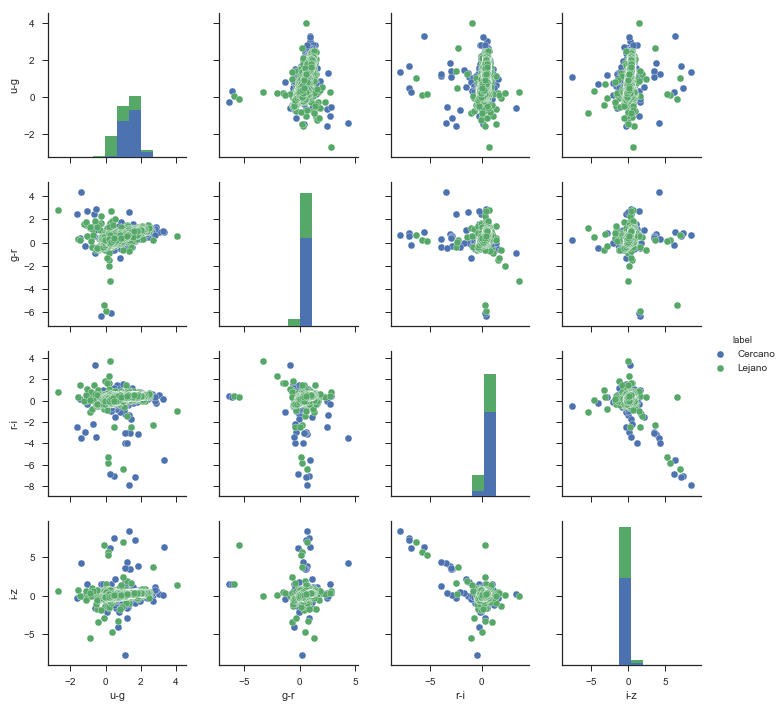

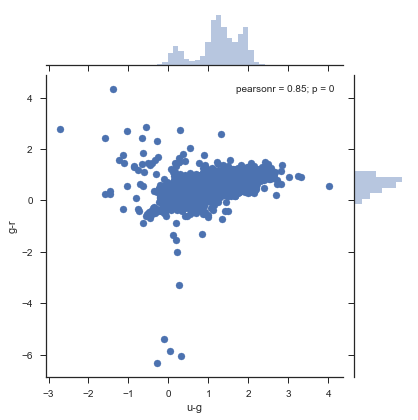

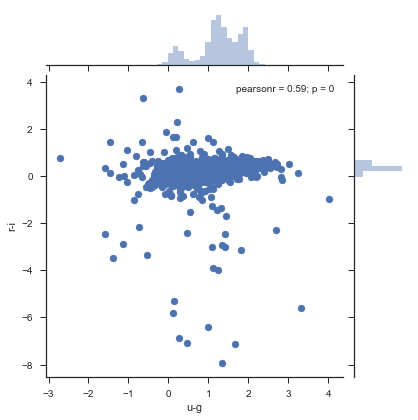

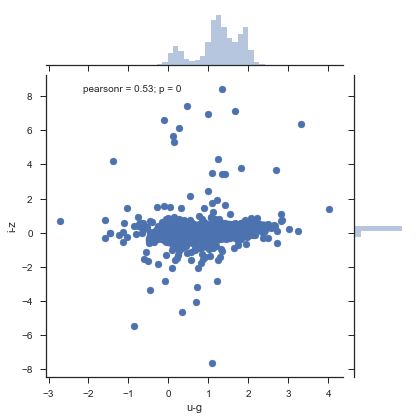

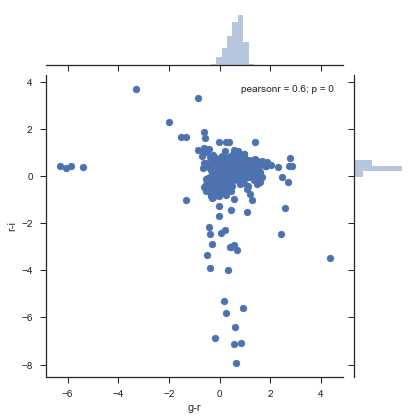

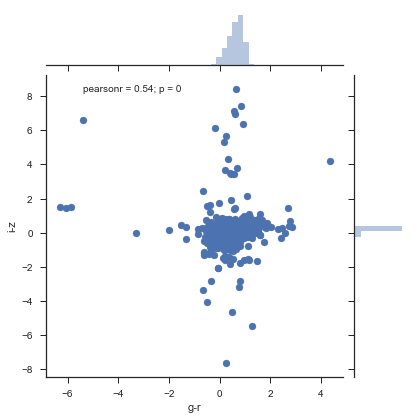

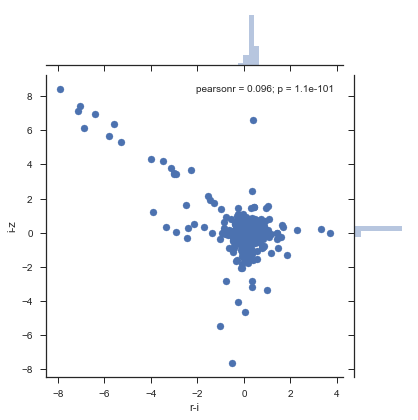

In [11]:
sns.set(style="ticks",color_codes=True)
sns.pairplot(new_df,vars=["u-g", "g-r", "r-i", "i-z"],hue="label")
sns.jointplot(new_df['u-g'], new_df['g-r'], kind='scatter')
sns.jointplot(new_df['u-g'], new_df['r-i'], kind='scatter')
sns.jointplot(new_df['u-g'], new_df['i-z'], kind='scatter')
sns.jointplot(new_df['g-r'], new_df['r-i'], kind='scatter')
sns.jointplot(new_df['g-r'], new_df['i-z'], kind='scatter')
sns.jointplot(new_df['r-i'], new_df['i-z'], kind='scatter')
plt.show()

Se escalan los datos y se crean los conjuntos de entrenamiento (75%) y de prueba (25%).

In [34]:
scaler = StandardScaler() 
Ydf= new_df.copy()
Xdf = new_df.copy()
Xdf.drop(['label'],axis=1,inplace=True)
Ydf.drop(['u-g','g-r','r-i','i-z'],axis=1,inplace=True)
X_scaled = pd.DataFrame(scaler.fit_transform(Xdf), columns=Xdf.columns)
y = Ydf['label']
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size=0.25, random_state=42)
X_train2, X_val, y_train2, y_val = train_test_split(X_train,y_train,test_size=0.25, random_state=42)

A continuación se muestran los errores de clasificación para SVM, Tree, Random Forest y Adaboost 

In [35]:
model= SVM()
model.set_params(C=20,kernel='rbf')
model.fit(X_train,y_train)
yhat_train = model.predict(X_train)
yhat_test = model.predict(X_test)
print("Error de Clasificación Train: %f"%(1-accuracy_score(y_train, yhat_train)))
print("Error de Clasificación Test: %f"%(1-accuracy_score(y_test, yhat_test)))

Error de Clasificación Train: 0.113411
Error de Clasificación Test: 0.118339


In [36]:
model= Tree()
model.set_params(max_depth=2,criterion='gini',splitter='best')
model.fit(X_train,y_train)
yhat_test = model.predict(X_test)
yhat_train = model.predict(X_train)
print("Error de Clasificación Train: %f"%(1-accuracy_score(y_train, yhat_train)))
print("Error de Clasificación Test: %f"%(1-accuracy_score(y_test, yhat_test)))

Error de Clasificación Train: 0.205511
Error de Clasificación Test: 0.203793


In [37]:
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier(criterion='gini',n_estimators=100,n_jobs=-1,random_state=44)
model.fit(X_train2,y_train2)
yhat_test = model.predict(X_test)
yhat_val = model.predict(X_val)
yhat_train = model.predict(X_train2)
print("Error de Clasificación Validation: %f"%(1-accuracy_score(y_val, yhat_val)))
print("Error de Clasificación Train: %f"%(1-accuracy_score(y_train2, yhat_train)))
print("Error de Clasificación Test: %f"%(1-accuracy_score(y_test, yhat_test)))

Error de Clasificación Validation: 0.120879
Error de Clasificación Train: 0.000036
Error de Clasificación Test: 0.121619


In [38]:
from sklearn.ensemble import AdaBoostClassifier
model=AdaBoostClassifier(base_estimator=Tree(criterion='gini',splitter='best',max_depth=20), n_estimators=100,random_state=44)
model.fit(X_train2,y_train2)
yhat_test = model.predict(X_test)
yhat_val = model.predict(X_val)
yhat_train = model.predict(X_train2)
print("Error de Clasificación Validation: %f"%(1-accuracy_score(y_val, yhat_val)))
print("Error de Clasificación Train: %f"%(1-accuracy_score(y_train2, yhat_train)))
print("Error de Clasificación Test: %f"%(1-accuracy_score(y_test, yhat_test)))

Error de Clasificación Validation: 0.127494
Error de Clasificación Train: 0.000000
Error de Clasificación Test: 0.125540


## Clasificación de Redshift mediante imágenes jpeg y redes neuronales convolucionales

A continuación intentamos realizar la predicción mediante imágenes en jpeg de las galaxias.
En primer lugar se cargan las imagenes de http://skyserver.sdss.org/dr12 a partir del RA y DEC a la carpeta /images/ relativo a la dirección de este documento.
Las imagenes tienen dimensión de 120x120, pesan cerca de 2kb.
Para disminuir el tiempo de cómputo se trabaja con una muestra del 10% de los datos, es decir, 4999 imágenes.

In [46]:
dfsample=new_df.sample(frac=0.1,random_state=44)
train2,test = train_test_split(dfsample, test_size=0.25, random_state=44)
train,validation=train_test_split(train2,test_size=0.25,random_state=44)
print("Dataframe shape: ",dfsample.shape)
print("Train shape: ",train.shape)
print("Validation shape: ",validation.shape)
print("Test shape: ",test.shape)

Dataframe shape:  (4999, 10)
Train shape:  (2811, 10)
Validation shape:  (938, 10)
Test shape:  (1250, 10)


In [28]:
dfsample.label.value_counts()

Cercano    3095
Lejano     1904
Name: label, dtype: int64

In [29]:
train.label.value_counts()

Cercano    1722
Lejano     1089
Name: label, dtype: int64

In [47]:
trainDataDir="./TrainImages/"
validationDataDir="./ValidationImages/"
testDataDir="./TestImages/"
imgWidth=120
imgHeight=120

In [48]:
import os
def downloadImages(df,directory):#descarga de imagenes a partir del RA y DEC del dataframe 
    if not os.path.exists(directory):
        os.makedirs(directory)
    link="http://skyserver.sdss.org/dr12/SkyserverWS/ImgCutout/getjpeg?TaskName=Skyserver.Chart.List&ra=261.89394&dec=53.486103&scale=1&width=120&height=120&opt="
    link1="http://skyserver.sdss.org/dr12/SkyserverWS/ImgCutout/getjpeg?TaskName=Skyserver.Chart.List&ra="
    link2="&dec="
    link3="&scale=1&width="+str(imgWidth)+"&height="+str(imgHeight)+"&opt="
    df.apply(lambda x: urllib.request.urlretrieve(link1+x['ra']+link2+x['dec']+link3,directory+x['ra']+","+x['dec']+".jpeg"), axis=1)


In [49]:
downloadImages(train, trainDataDir)
downloadImages(validation, validationDataDir)
downloadImages(test, testDataDir)

Luego se pasan las imagenes a pixeles y se procesan para luego poder usarlas en una red neuronal convolucional.

In [25]:
def create_pixel_df(path,cantidad,df_fuente):
    columnas = []
    etiqueta = []
    df = {}
    for i in range(1,imgWidth*imgHeight*3+1):
        columnas.append("pixel"+str(i))
    for i in range(cantidad):
        foto = path+os.listdir(path)[i]
        img = PIL.Image.open(foto)
       
        full_string = os.listdir(path)[i]
        short_string = os.path.splitext(full_string)[0]
        ra,dec = short_string.split(',')
        asignador = df_fuente.loc[(df_fuente['ra'] == ra) & (df_fuente['dec'] == dec)]
       
        arr = np.array(img)
        arr2 = np.array(img.getdata(0))
        arr22 = np.array(img.getdata(1))
        arr23 =np.array(img.getdata(2))
        arr3 = np.concatenate((np.concatenate((arr2,arr22),axis=0),arr23),axis=0)

        etiqueta.append(asignador['label'].values)
        df[i] = arr3
    df2 = pd.DataFrame(df).T
    df2.columns = columnas
    df3 = pd.DataFrame(etiqueta,columns = ['label'])
    df_final =pd.concat([df2, df3], axis=1)
    return df_final

In [26]:
traindf=create_pixel_df(trainDataDir,train.shape[0],train)

In [17]:
validationdf=create_pixel_df(validationDataDir,validation.shape[0],validation)

In [18]:
testdf=create_pixel_df(testDataDir,test.shape[0],test)

In [19]:
traindf.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel43192,pixel43193,pixel43194,pixel43195,pixel43196,pixel43197,pixel43198,pixel43199,pixel43200,label
0,5,7,10,12,11,10,9,9,9,7,...,0,4,4,4,4,4,3,1,1,Cercano
1,0,1,2,3,3,3,3,2,1,4,...,4,1,0,0,7,17,18,9,0,Cercano
2,1,2,2,3,3,4,4,5,0,1,...,8,3,3,3,3,3,3,3,3,Lejano
3,7,4,3,4,7,9,8,6,12,9,...,0,6,5,3,2,3,5,7,9,Lejano
4,6,6,6,6,6,6,6,6,3,5,...,2,0,0,3,3,2,0,0,0,Cercano


In [20]:
ytrain=traindf["label"]
xtrain=traindf.drop("label",axis=1)

In [21]:
yval=validationdf["label"]
xval=validationdf.drop("label",axis=1)

In [22]:
ytest=testdf["label"]
xtest=testdf.drop("label",axis=1)

In [23]:
ytrain2=[]
for item in ytrain:
    if item=="Cercano":
        ytrain2.append(0)
    else:
        ytrain2.append(1)
yval2=[]
for item in yval:
    if item=="Cercano":
        yval2.append(0)
    else:
        yval2.append(1)
ytest2=[]
for item in ytest:
    if item=="Cercano":
        ytest2.append(0)
    else:
        ytest2.append(1)

In [24]:
xtrain = xtrain.apply(lambda x: x/255,axis = 1)
xval = xval.apply(lambda x: x/255,axis = 1)
xtest = xtest.apply(lambda x: x/255,axis = 1)
xtrain = xtrain.as_matrix().reshape(xtrain.shape[0],120, 120,3)
xval = xval.as_matrix().reshape(xval.shape[0],120, 120,3)
xtest = xtest.as_matrix().reshape(xtest.shape[0],120, 120,3)

Al ya estar los datos listos, se pasan a una red neuronal convolucional en donde se fue iterando sobre varios modelos, agregando y quitando capas y modificando el numero de neuronas hasta que se llego al modelo que se muestra a continuación
que es el modelo con mejores resultados sobre el conjunto de validación, con el cual se fue cambiando el batch size, la cantidad de epocas y el optimizer para poder observar distintos graficos con sus resultados.

In [32]:
def createModel(width,height):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(120,120,3)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Conv2D(64, (3, 3), padding='same', activation='tanh'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Conv2D(64, (3, 3), padding='same', activation='tanh'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='tanh'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3, 3), padding='same', activation='tanh'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
   
    return model

Train on 2811 samples, validate on 938 samples
Epoch 1/5
2811/2811 [==============================] - 8s 3ms/step - loss: 0.6939 - acc: 0.6129 - val_loss: 0.6159 - val_acc: 0.7484
Epoch 2/5
2811/2811 [==============================] - 8s 3ms/step - loss: 0.5985 - acc: 0.6994 - val_loss: 0.5568 - val_acc: 0.7569
Epoch 3/5
2811/2811 [==============================] - 8s 3ms/step - loss: 0.5666 - acc: 0.7186 - val_loss: 0.4865 - val_acc: 0.7783
Epoch 4/5
2811/2811 [==============================] - 8s 3ms/step - loss: 0.5476 - acc: 0.7414 - val_loss: 0.5110 - val_acc: 0.7548
Epoch 5/5
2811/2811 [==============================] - 8s 3ms/step - loss: 0.5071 - acc: 0.7499 - val_loss: 0.5979 - val_acc: 0.6535


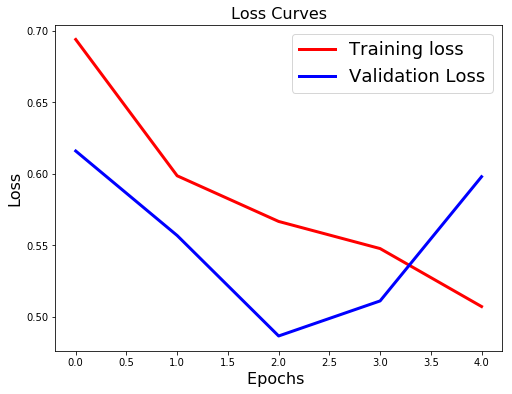

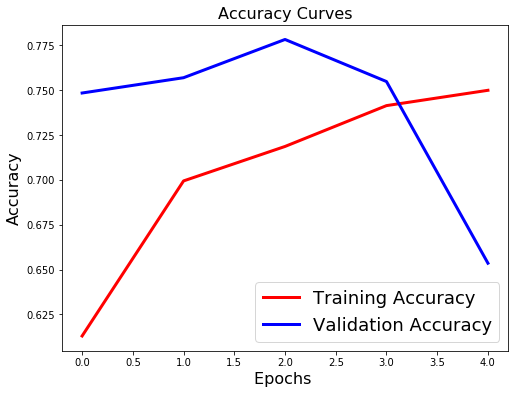

1250/1250 [==============================] - 1s 975us/step


[0.58981152744293208, 0.69999999999999996]

In [27]:
model1 = createModel(imgWidth,imgHeight)
batch_size = 32
epochs = 5
model1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

history = model1.fit(xtrain, to_categorical(ytrain2), batch_size=batch_size, epochs=epochs, verbose=1, 
                   validation_data=(xval, to_categorical(yval2)))

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

plt.show()

model1.evaluate(xtest, to_categorical(ytest2))

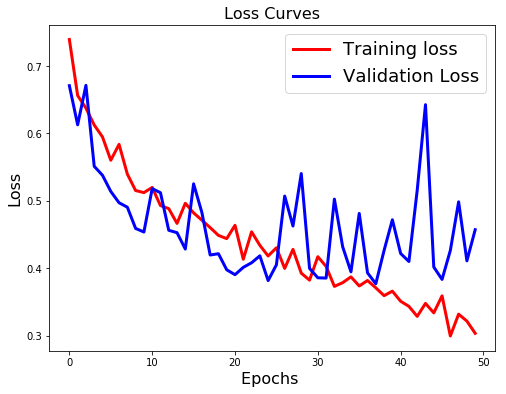

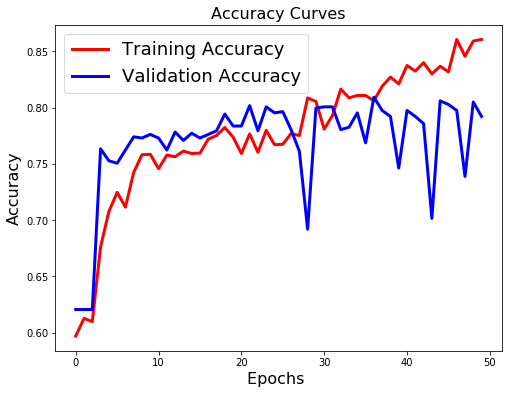

1250/1250 [==============================] - 1s 980us/step


[0.50003499134778973, 0.81200000000000006]

In [33]:
model1 = createModel(imgWidth,imgHeight)
batch_size = 128
epochs = 50
model1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

history = model1.fit(xtrain, to_categorical(ytrain2), batch_size=batch_size, epochs=epochs, verbose=0, 
                   validation_data=(xval, to_categorical(yval2)))

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

plt.show()

model1.evaluate(xtest, to_categorical(ytest2))

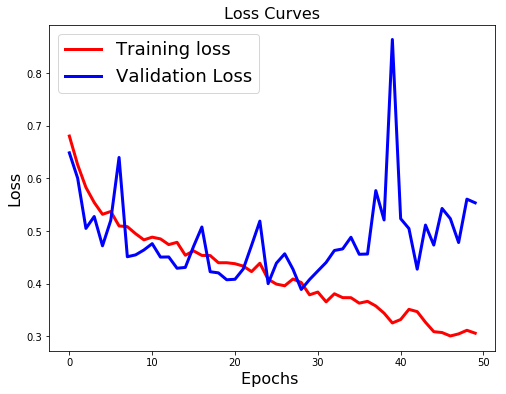

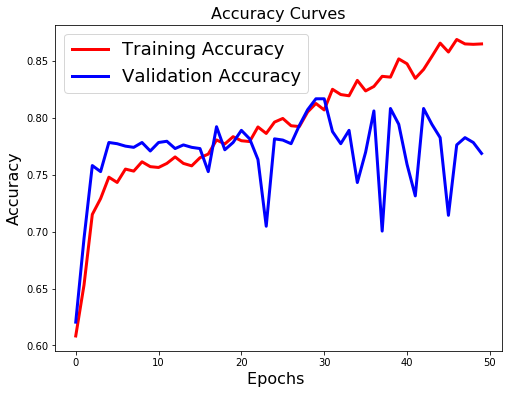

1250/1250 [==============================] - 1s 987us/step


[0.48817188307046888, 0.80959999999999999]

In [29]:
model1 = createModel(imgWidth,imgHeight)
batch_size = 64
epochs = 50
model1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

history = model1.fit(xtrain, to_categorical(ytrain2), batch_size=batch_size, epochs=epochs, verbose=0, 
                   validation_data=(xval, to_categorical(yval2)))

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

plt.show()

model1.evaluate(xtest, to_categorical(ytest2))

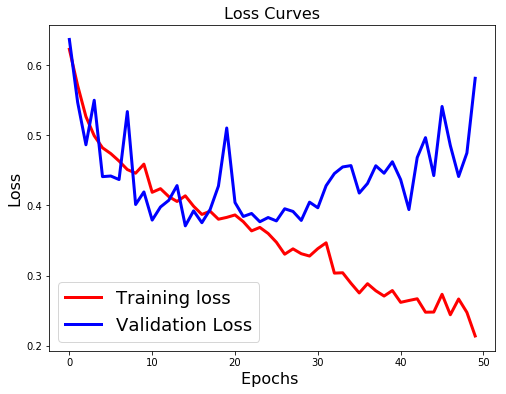

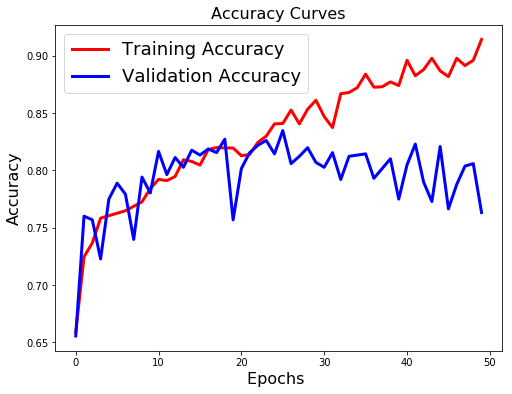

1250/1250 [==============================] - 1s 992us/step


[0.54575725975036626, 0.79120000000000001]

In [30]:

model1 = createModel(imgWidth,imgHeight)
batch_size = 64
epochs = 50
model1.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

history = model1.fit(xtrain, to_categorical(ytrain2), batch_size=batch_size, epochs=epochs, verbose=0, 
                   validation_data=(xval, to_categorical(yval2)))

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

plt.show()

model1.evaluate(xtest, to_categorical(ytest2))


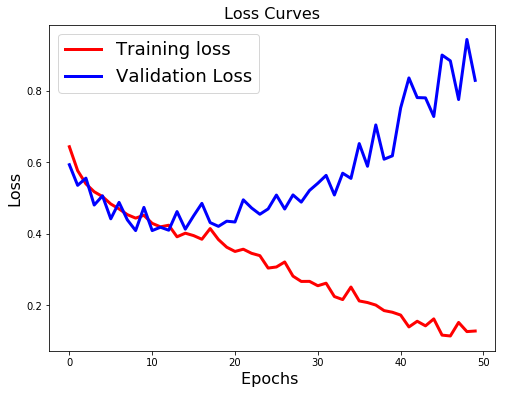

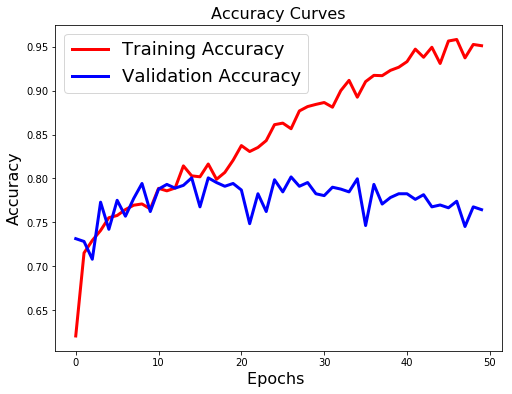

1250/1250 [==============================] - 1s 994us/step


[0.70634446134567264, 0.79039999999999999]

In [31]:
model1 = createModel(imgWidth,imgHeight)
batch_size = 64
epochs = 50
model1.compile(optimizer=Adam(lr=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

history = model1.fit(xtrain, to_categorical(ytrain2), batch_size=batch_size, epochs=epochs, verbose=0, 
                   validation_data=(xval, to_categorical(yval2)))

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

plt.show()

model1.evaluate(xtest, to_categorical(ytest2))


Cabe mencionar, que de los resultados obtenidos, el primer número es el loss y el segundo es el score.

## Regresión de Redshift mediante imágenes jpeg y redes convolucionales

A continuación se realizará una regresión para predecir el redshift mediante redes neuronales convolucionales, con los mismos datos que la predicción anterior.



In [36]:
dfsample=reg_df.sample(frac=0.1,random_state=44)
train2,test = train_test_split(dfsample, test_size=0.25, random_state=44)
train,validation=train_test_split(train2,test_size=0.25,random_state=44)
print("Dataframe shape: ",dfsample.shape)
print("Train shape: ",train.shape)
print("Validation shape: ",validation.shape)
print("Test shape: ",test.shape)

Dataframe shape:  (4999, 10)
Train shape:  (2811, 10)
Validation shape:  (938, 10)
Test shape:  (1250, 10)


In [37]:
trainDataDir="./TrainImages/"
validationDataDir="./ValidationImages/"
testDataDir="./TestImages/"
imgWidth=120
imgHeight=120

In [38]:
def create_pixel_df(path,cantidad,df_fuente):
    columnas = []
    etiqueta = []
    df = {}
    for i in range(1,imgWidth*imgHeight*3+1):
        columnas.append("pixel"+str(i))
    for i in range(cantidad):
        foto = path+os.listdir(path)[i]
        img = PIL.Image.open(foto)
       
        full_string = os.listdir(path)[i]
        short_string = os.path.splitext(full_string)[0]
        ra,dec = short_string.split(',')
        asignador = df_fuente.loc[(df_fuente['ra'] == ra) & (df_fuente['dec'] == dec)]
       
        arr = np.array(img)
        arr2 = np.array(img.getdata(0))
        arr22 = np.array(img.getdata(1))
        arr23 =np.array(img.getdata(2))
        arr3 = np.concatenate((np.concatenate((arr2,arr22),axis=0),arr23),axis=0)

        etiqueta.append(asignador['redshift'].values)
        df[i] = arr3
    df2 = pd.DataFrame(df).T
    df2.columns = columnas
    df3 = pd.DataFrame(etiqueta,columns = ['redshift'])
    df_final =pd.concat([df2, df3], axis=1)
    return df_final

In [39]:
traindf=create_pixel_df(trainDataDir,train.shape[0],train)

In [40]:
validationdf=create_pixel_df(validationDataDir,validation.shape[0],validation)

In [41]:
testdf=create_pixel_df(testDataDir,test.shape[0],test)

In [42]:
traindf.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel43192,pixel43193,pixel43194,pixel43195,pixel43196,pixel43197,pixel43198,pixel43199,pixel43200,redshift
0,5,7,10,12,11,10,9,9,9,7,...,0,4,4,4,4,4,3,1,1,0.061479
1,0,1,2,3,3,3,3,2,1,4,...,4,1,0,0,7,17,18,9,0,0.076532
2,1,2,2,3,3,4,4,5,0,1,...,8,3,3,3,3,3,3,3,3,1.055858
3,7,4,3,4,7,9,8,6,12,9,...,0,6,5,3,2,3,5,7,9,0.530220
4,6,6,6,6,6,6,6,6,3,5,...,2,0,0,3,3,2,0,0,0,0.017116


In [43]:
ytrain=traindf["redshift"]
xtrain=traindf.drop("redshift",axis=1)

In [44]:
yval=validationdf["redshift"]
xval=validationdf.drop("redshift",axis=1)

In [45]:
ytest=testdf["redshift"]
xtest=testdf.drop("redshift",axis=1)

In [47]:
xtrain = xtrain.apply(lambda x: x/255,axis = 1)
xval = xval.apply(lambda x: x/255,axis = 1)
xtest = xtest.apply(lambda x: x/255,axis = 1)
xtrain = xtrain.as_matrix().reshape(xtrain.shape[0],120, 120,3)
xval = xval.as_matrix().reshape(xval.shape[0],120, 120,3)
xtest = xtest.as_matrix().reshape(xtest.shape[0],120, 120,3)

In [48]:
def createModel():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(120,120,3)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Conv2D(64, (3, 3), padding='same', activation='tanh'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Conv2D(64, (3, 3), padding='same', activation='tanh'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='tanh'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3, 3), padding='same', activation='tanh'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='softmax'))
    model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['accuracy'])

    return model

In [49]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
batch_size = 128
epochs = 10


reg = KerasRegressor(build_fn=createModel, epochs=epochs, batch_size=batch_size, verbose=1)
reg.fit(xtrain, ytrain,validation_data=(xval,yval))


Train on 2811 samples, validate on 938 samples
Epoch 1/10
2811/2811 [==============================] - 11s 4ms/step - loss: 0.8127 - acc: 0.0000e+00 - val_loss: 0.8004 - val_acc: 0.0000e+00
Epoch 2/10
2811/2811 [==============================] - 7s 2ms/step - loss: 0.8127 - acc: 0.0000e+00 - val_loss: 0.8004 - val_acc: 0.0000e+00
Epoch 3/10
2811/2811 [==============================] - 7s 2ms/step - loss: 0.8127 - acc: 0.0000e+00 - val_loss: 0.8004 - val_acc: 0.0000e+00
Epoch 4/10
2811/2811 [==============================] - 7s 2ms/step - loss: 0.8127 - acc: 0.0000e+00 - val_loss: 0.8004 - val_acc: 0.0000e+00
Epoch 5/10
2811/2811 [==============================] - 7s 2ms/step - loss: 0.8127 - acc: 0.0000e+00 - val_loss: 0.8004 - val_acc: 0.0000e+00
Epoch 6/10
2811/2811 [==============================] - 7s 2ms/step - loss: 0.8127 - acc: 0.0000e+00 - val_loss: 0.8004 - val_acc: 0.0000e+00
Epoch 7/10
2811/2811 [==============================] - 7s 3ms/step - loss: 0.8127 - acc: 0.0000e+00

In [51]:
from sklearn.metrics import mean_squared_error
print("Error cuadratico medio: ",mean_squared_error(ytest,reg.predict(xtest)))

1250/1250 [==============================] - 1s 874us/step
Error cuadratico medio:  0.825367120819


## Conclusiones

Del lado de la obtención de datos, podemos concluir que se necesita harto trabajo en el desarrollo de software, ya que el obtener datos de las paginas fue bastante tedioso, por el lado del metadata, se usaron consultas sql a una base de datos, en donde algunas campos no eran muy intuitivos y se tuvo que buscar en la documentacion que variables estaba en que tabla. Por el lado de las imagenes, se utilizo el ra y dec de la metadata para buscarlas en dr12, pero no habia forma de descargar todas las imagenes, excepto ir apretando 1 por 1, haciendo muy tedioso descargar 10000 imagenes, por lo que terminamos usando un script a la api para poder descargar todo.

En el lado del análisis de datos podemos concluir que el análisis de redhisft a través de imágenes de colores es claramente posible, ya que se puede obtener valores similares a los obtenidos con metada, utilizando técnicas orientadas a imágenes (CNN) y un par de capas en la neurona. Mas a futuro se puede mejorar este trabajo haciendo feature crafting, generando mejores estadísticos para los metadados y image augmentation para las redes neuronales convoluciones, evitando el overfitting sobre las maquinas entrenadas.

Por último, por el lado de la regresión, se puede observar que los resultados obtenidos son bastante malos, obteniendo un error por sobre el 80% con un accurracy de 0, por lo que el metodo de regresión, con los datos con los que se trabajo almenos, no sirve para predecir el redshift.